In [1]:
#Make sure you are in directory: Mori-Zwanzig-Autoencoder/
import os
os.chdir("../")
print(os.getcwd())

C:\Users\ismae\Desktop\PhD_codes\TurbulentEncoderTransformerDecoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [3]:
torch.cuda.empty_cache()
exp_dir = "Trained_Models/Kolmo2D_new"

exp_name = "sl30_obs64_bs64_attblks2_atthds8_tr0_ph30_nhd64_0.0005_"
model = Eval_MZA(exp_dir, exp_name)

########## Imp Info ##########
System:  2DCyl


Epoch with Minimum train_error:  4966
Epoch with Minimum test_error:  4954


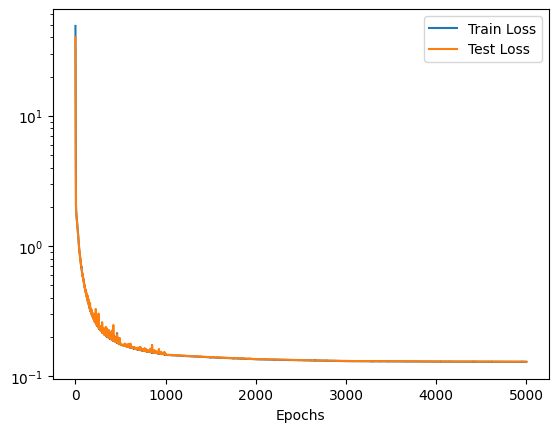

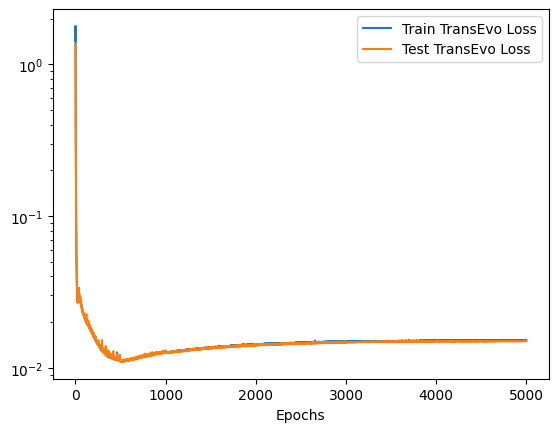

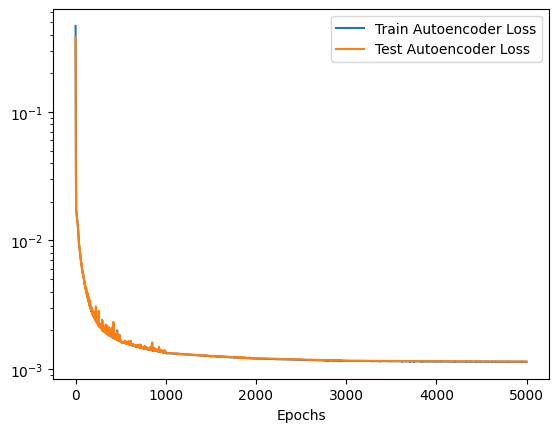

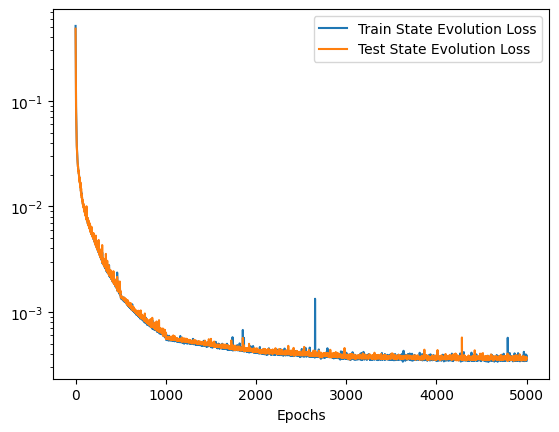

In [4]:
model.plot_learning_curves()

In [5]:
model.load_weights(min_test_loss = True)

In [7]:
kolmo_flow = "Data/Kolmogorov/kolmo_filtered_100s_8ens.npy"
Phi_test = np.load(kolmo_flow) 
Phi_test = torch.tensor(Phi_test, dtype = torch.float32).to(torch.device("cuda"))
Phi_test = Phi_test[:, 1::2, :]
N, T, D = Phi_test.shape
Phi_test.shape

torch.Size([8, 400, 8192])

In [8]:
timesteps = 800
initial_step = 0
initial_conditions = Phi_test[:,initial_step,:]
initial_conditions.shape

torch.Size([8, 8192])

In [9]:
device = torch.device("cuda")
x_ms_hat, Phi_ms_hat = [], []
print("ic shape:", initial_conditions.shape)

for i in range(N):
    
    initial_condition = initial_conditions[i, :]
    std = torch.std(initial_condition)
    x_hat_temp, Phi_hat_temp = model.predict_multistep(initial_condition.unsqueeze(0), timesteps)
    x_ms_hat.append(x_hat_temp)
    Phi_ms_hat.append(Phi_hat_temp)
    print(x_hat_temp.shape, Phi_hat_temp.shape)

x_ms_hat = torch.cat(x_ms_hat, dim = 0)
Phi_ms_hat = torch.cat(Phi_ms_hat, dim = 0)
print(Phi_ms_hat.shape, x_ms_hat.shape)

ic shape: torch.Size([8, 8192])
torch.Size([1, 801, 64]) torch.Size([1, 801, 8192])
torch.Size([1, 801, 64]) torch.Size([1, 801, 8192])
torch.Size([1, 801, 64]) torch.Size([1, 801, 8192])
torch.Size([1, 801, 64]) torch.Size([1, 801, 8192])
torch.Size([1, 801, 64]) torch.Size([1, 801, 8192])
torch.Size([1, 801, 64]) torch.Size([1, 801, 8192])
torch.Size([1, 801, 64]) torch.Size([1, 801, 8192])
torch.Size([1, 801, 64]) torch.Size([1, 801, 8192])
torch.Size([8, 801, 8192]) torch.Size([8, 801, 64])


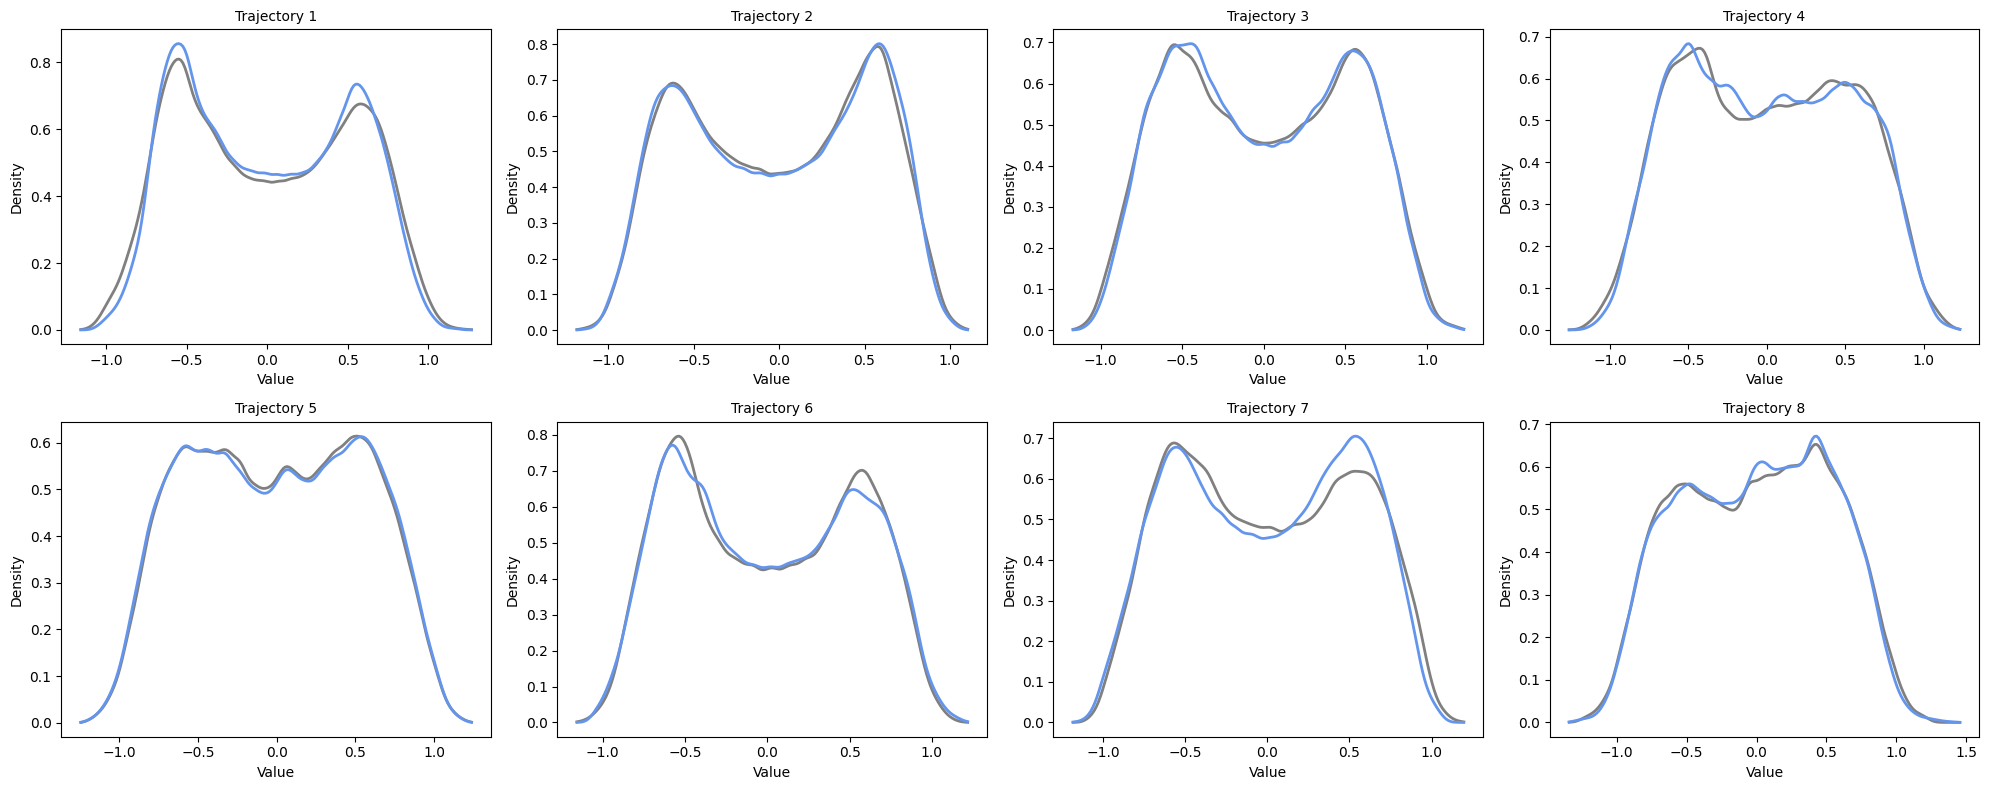


=== Metrics Summary ===
Trajectory 0 - Rel L1: 0.3866 | Rel L2: 0.4333 | W-dist: 0.0161
Trajectory 1 - Rel L1: 0.3869 | Rel L2: 0.4741 | W-dist: 0.0058
Trajectory 2 - Rel L1: 0.1404 | Rel L2: 0.1639 | W-dist: 0.0076
Trajectory 3 - Rel L1: 0.4340 | Rel L2: 0.4970 | W-dist: 0.0075
Trajectory 4 - Rel L1: 0.2270 | Rel L2: 0.2504 | W-dist: 0.0050
Trajectory 5 - Rel L1: 0.2730 | Rel L2: 0.3330 | W-dist: 0.0059
Trajectory 6 - Rel L1: 0.8073 | Rel L2: 0.9861 | W-dist: 0.0163
Trajectory 7 - Rel L1: 0.4014 | Rel L2: 0.4396 | W-dist: 0.0081

Average Relative L1 Error: 0.3821
Average Relative L2 Error: 0.4472
Average Wasserstein Distance: 0.0090


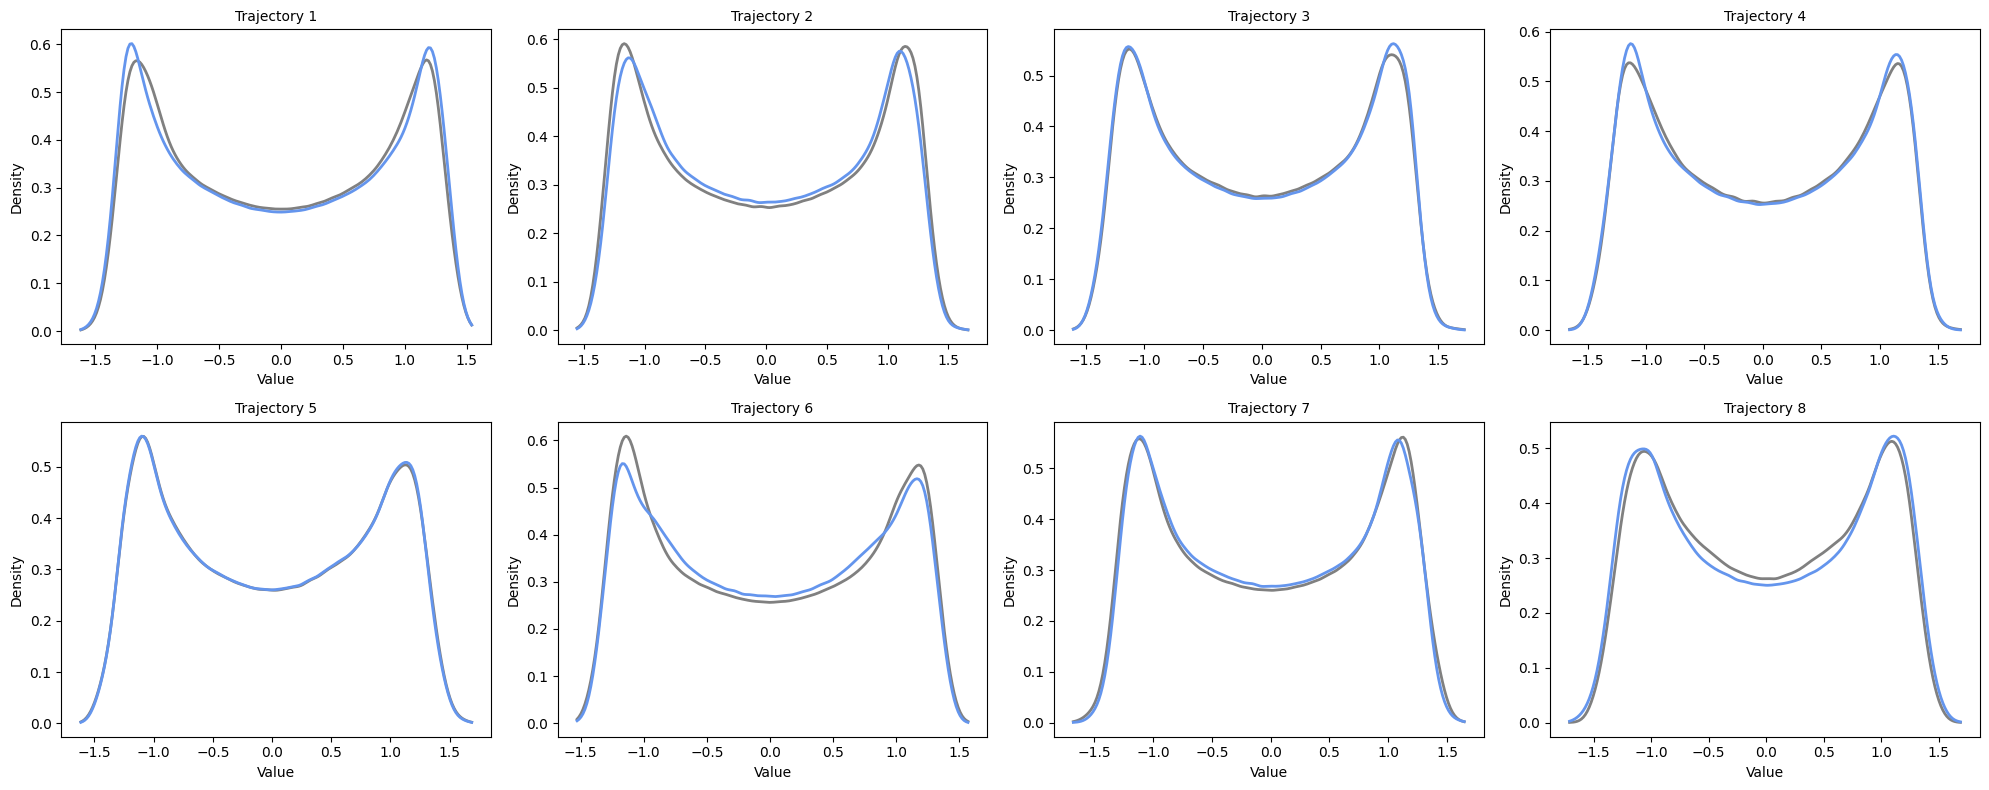


=== Metrics Summary ===
Trajectory 0 - Rel L1: 0.2256 | Rel L2: 0.2562 | W-dist: 0.0145
Trajectory 1 - Rel L1: 0.1908 | Rel L2: 0.2238 | W-dist: 0.0213
Trajectory 2 - Rel L1: 0.0996 | Rel L2: 0.1166 | W-dist: 0.0068
Trajectory 3 - Rel L1: 0.2086 | Rel L2: 0.2486 | W-dist: 0.0068
Trajectory 4 - Rel L1: 0.1189 | Rel L2: 0.1362 | W-dist: 0.0015
Trajectory 5 - Rel L1: 0.1635 | Rel L2: 0.1997 | W-dist: 0.0212
Trajectory 6 - Rel L1: 0.3586 | Rel L2: 0.4326 | W-dist: 0.0147
Trajectory 7 - Rel L1: 0.2162 | Rel L2: 0.2547 | W-dist: 0.0269

Average Relative L1 Error: 0.1977
Average Relative L2 Error: 0.2335
Average Wasserstein Distance: 0.0142


In [13]:
from scipy.stats import gaussian_kde
from scipy.stats import wasserstein_distance

def analyze_predictions(Phi_test, Phi_ms_hat):
    N, T, D = Phi_test.shape
    timesteps = Phi_ms_hat.shape[1]

    l1_errors = []
    l2_errors = []
    w_dists = []

    pdf_data = []

    for i in range(N):
        true = Phi_test[i]          
        pred = Phi_ms_hat[i, :T]

        rel_l1 = np.mean(np.abs(true - pred)) / (np.mean(np.abs(true)) + 1e-8)
        rel_l2 = np.linalg.norm(true - pred) / (np.linalg.norm(true) + 1e-8)

        l1_errors.append(rel_l1)
        l2_errors.append(rel_l2)

        true_full = true.flatten()
        pred_full = pred.flatten()

        kde_true = gaussian_kde(true_full)
        kde_pred = gaussian_kde(pred_full)

        xmin = min(true_full.min(), pred_full.min())
        xmax = max(true_full.max(), pred_full.max())
        x_eval = np.linspace(xmin, xmax, 200)

        pdf_true = kde_true(x_eval)
        pdf_pred = kde_pred(x_eval)

        w_dist = wasserstein_distance(true_full, pred_full)
        w_dists.append(w_dist)

        pdf_data.append((x_eval, pdf_true, pdf_pred))


    fig, axes = plt.subplots(2, 4, figsize=(20, 8))  # 2x4 grid
    axes = axes.flatten()

    for i in range(N):
        x_eval, pdf_true, pdf_pred = pdf_data[i]
        axes[i].plot(x_eval, pdf_true, label='True PDF', linewidth=2, color='grey')
        axes[i].plot(x_eval, pdf_pred, label='Predicted PDF', linewidth=2, color='cornflowerblue')
        axes[i].set_title(f"Trajectory {i+1}", fontsize=10)
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    print("\n=== Metrics Summary ===")
    for i in range(N):
        print(f"Trajectory {i} - Rel L1: {l1_errors[i]:.4f} | Rel L2: {l2_errors[i]:.4f} | W-dist: {w_dists[i]:.4f}")
    
    print(f"\nAverage Relative L1 Error: {np.mean(l1_errors):.4f}")
    print(f"Average Relative L2 Error: {np.mean(l2_errors):.4f}")
    print(f"Average Wasserstein Distance: {np.mean(w_dists):.4f}")

    return l1_errors, l2_errors, w_dists

N, T, D = Phi_test.shape
_, timesteps, _ = Phi_ms_hat.shape

U_ms_hat = Phi_ms_hat[:, :, :D//2].detach().cpu().numpy() 
V_ms_hat = Phi_ms_hat[:, :, D//2:].detach().cpu().numpy() 
U = Phi_test[:, :, :D//2].detach().cpu().numpy()
V = Phi_test[:, :, D//2:].detach().cpu().numpy()

l1_U, l2_U, w_dist_U = analyze_predictions(U, U_ms_hat)
l1_V, l2_V, w_dist_V = analyze_predictions(V, V_ms_hat)

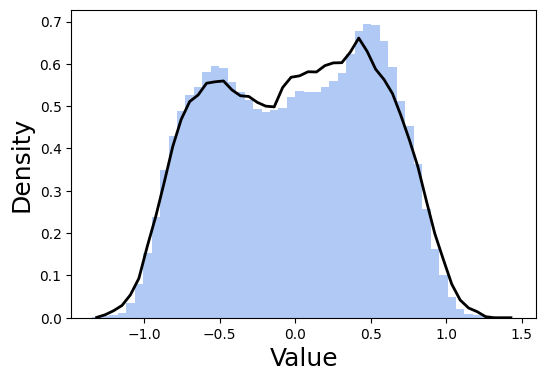

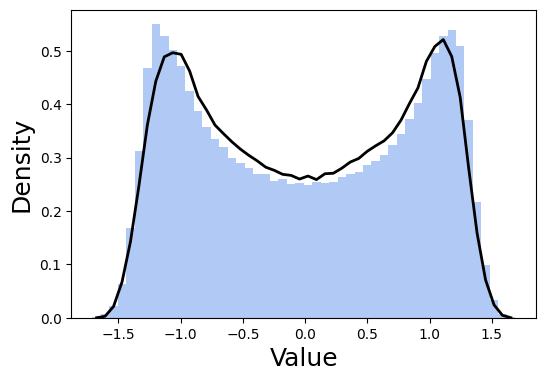

In [14]:
def analyze_predictions(Phi_test, Phi_ms_hat, traj):
    
    N, T, D = Phi_test.shape
    timesteps = Phi_ms_hat.shape[1]

    true = Phi_test[traj]          
    pred = Phi_ms_hat[traj]    

    true_full = true.flatten()
    pred_full = pred.flatten()

    bins = 50
    range_min = min(true_full.min(), pred_full.min())
    range_max = max(true_full.max(), pred_full.max())
    hist_range = (range_min, range_max)
    
    pdf_ref, bin_edges = np.histogram(true_full, bins=bins, range=hist_range, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    pdf_pred, _ = np.histogram(pred_full, bins=bin_edges, density=True)

    fig = plt.figure(figsize = (6,4))
    plt.bar(bin_centers, pdf_pred, width=bin_edges[1]-bin_edges[0], 
           color='cornflowerblue', alpha=0.5)
    plt.plot(bin_centers, pdf_ref, color='black', linewidth=2)

    plt.xlabel("Value", fontsize = 18)
    plt.ylabel("Density", fontsize = 18)
    plt.show()


N, T, D = Phi_test.shape
_, timesteps, _ = Phi_ms_hat.shape

U_ms_hat = Phi_ms_hat[:, :, :D//2].detach().cpu().numpy() 
V_ms_hat = Phi_ms_hat[:, :, D//2:].detach().cpu().numpy() 
U = Phi_test[:, :, :D//2].detach().cpu().numpy()
V = Phi_test[:, :, D//2:].detach().cpu().numpy()

analyze_predictions(U, U_ms_hat, 7)
analyze_predictions(V, V_ms_hat, 7)

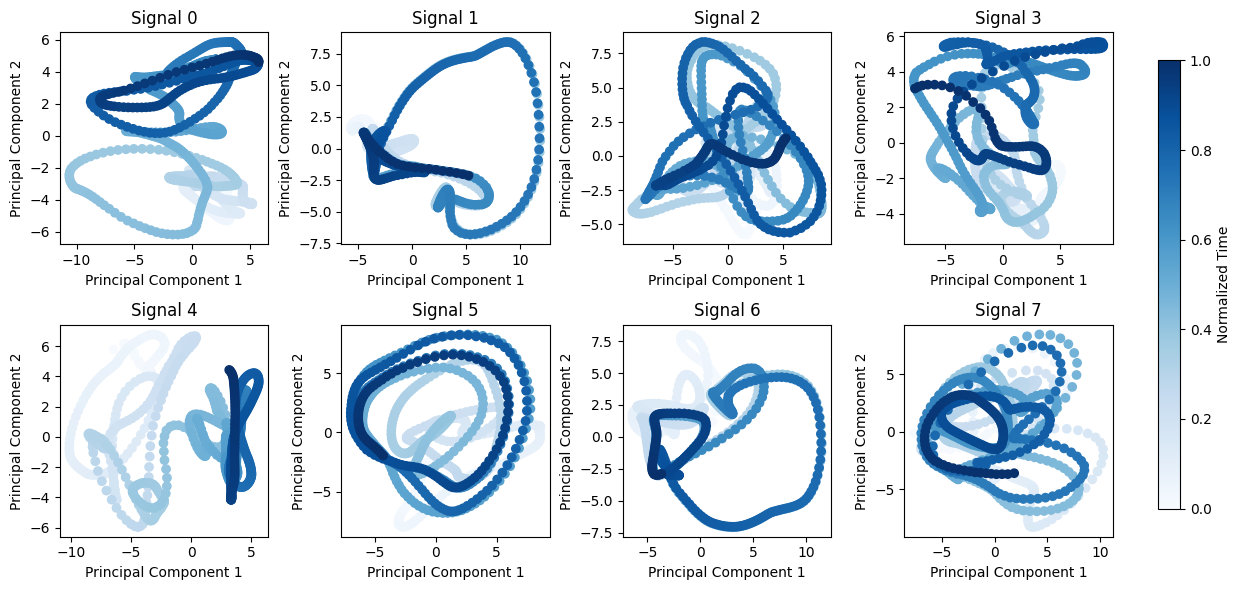

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

N = 8  

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()

for i in range(N):
    latent_var = x_ms_hat[i].detach().cpu().numpy()
    
    x = StandardScaler().fit_transform(latent_var)
    pca_latent = PCA(n_components=2)
    PCA_result = pca_latent.fit_transform(x)
    
    scatter = axs[i].scatter(
        PCA_result[:, 0], PCA_result[:, 1], 
        c=np.linspace(0, 1, x.shape[0]), cmap='Blues'
    )
    
    axs[i].set_title(f'Signal {i}')
    axs[i].set_xlabel('Principal Component 1')
    axs[i].set_ylabel('Principal Component 2')


fig.tight_layout()


cbar = fig.colorbar(scatter, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Normalized Time')

plt.show()

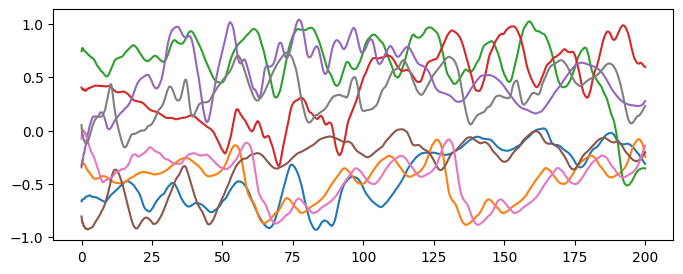

In [16]:
index = D//6

plt.figure(figsize=(8, 3))
for i in range(N) : 
    plt.plot(np.arange(timesteps)*0.25, Phi_ms_hat[i, :, index], label='Mean')

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = 30
traj_idx = 7
ens_traj = []
ens = 10
model.model.eval()
ens_Phi_traj = []
timesteps = 800
for j in range(ens):
    
    initial_condition = Phi_test[traj_idx:traj_idx+1, :1, :].to(device)
    padding  = torch.repeat_interleave(initial_condition, seq_len - 1, dim=1)
    initial_condition  = torch.cat((padding, initial_condition), dim = 1)
    Phi_tp = initial_condition
    print(f"Ensemble {j+1}")

    traj = []
    latent_traj = []
    for t in range(timesteps):
        
        x, mu, log_var = model.model.autoencoder.encode(Phi_tp)
        x = x[:, :-1, :]
        x_tp1 = model.model.transformer(x)
        Phi_tp1 = model.model.autoencoder.recover(x_tp1)     
        traj.append(Phi_tp1.detach().cpu())
        Phi_tp = torch.cat([Phi_tp, Phi_tp1.unsqueeze(0)], dim=1)[:, -seq_len :, :]
        
    ens_traj.append(torch.stack(traj))

    del Phi_tp, initial_condition, traj, x, mu, log_var, x_tp1, Phi_tp1
    torch.cuda.empty_cache()

ens_traj = torch.stack(ens_traj)  # [ens, time, batch, dim]
ens_traj_np = ens_traj[:, :, 0, :].numpy()
print(ens_traj_np.shape)

Ensemble 1
Ensemble 2
Ensemble 3
Ensemble 4
Ensemble 5
Ensemble 6
Ensemble 7
Ensemble 8
Ensemble 9
Ensemble 10
(10, 800, 8192)


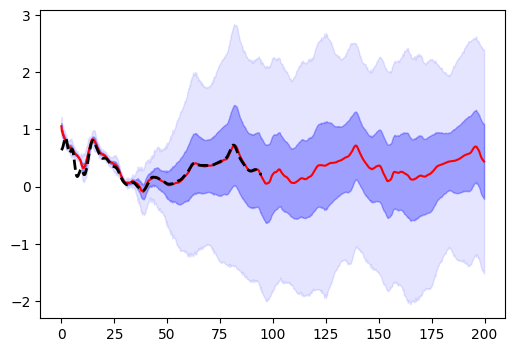

In [21]:
def position_to_index(field, x, y, width=64):
    if field == 'U' : 
        return y * width + x
    else : 
        return y * width + x + width**2 

N, T, D = ens_traj_np.shape
T_test = Phi_test.shape[1]
indices = np.arange(T)
index = position_to_index('V', 32, 62)
phase_shift = 20
std = np.std(ens_traj_np, axis=0)
mu = Phi_ms_hat[traj_idx, :-1, :]


plt.figure(figsize=(6, 4))

plt.plot(np.arange(T)*0.25, mu[:, index], label='Mean', color = 'red')
plt.plot(np.arange(T_test-phase_shift)*0.25, Phi_test[traj_idx,phase_shift:, index].detach().cpu().numpy(), color = 'black', alpha = 1, linestyle = '--', label = 'Test trajectory', linewidth = 2)

plt.fill_between(
    np.arange(T)*0.25,          # x-axis values
    mu[:, index] - std[:, index],    # lower bound (mean - std)
    mu[:, index] + std[:, index],    # upper bound (mean + std)
    color='b', alpha=0.3, label=r'$\pm \sigma$'
)

plt.fill_between(
    np.arange(T)*0.25,          # x-axis values
    mu[:, index] - 3*std[:, index],    # lower bound (mean - std)
    mu[:, index] + 3*std[:, index],    # upper bound (mean + std)
    color='b', alpha=0.1, label=r'$\pm 3\sigma$'
)

plt.show()

In [22]:
from scipy.stats import norm

y_true = Phi_test[traj_idx, phase_shift:, :].detach().cpu().numpy()
ens_traj_np_mean = mu[:T_test- phase_shift, :].detach().cpu().numpy()
ens_traj_np_std = std[:T_test-phase_shift, :]
print(y_true.shape, ens_traj_np_mean.shape, ens_traj_np_std.shape)
def get_PICP(sigma_factor, y, mu, std) :

    upper = mu + sigma_factor*std
    lower = mu - sigma_factor*std 
    coverage = np.mean((y >= lower) & (y_true <= upper))
    return coverage

coverage_1sigma = get_PICP(1, y_true,ens_traj_np_mean,ens_traj_np_std)*100
coverage_2sigma = get_PICP(2, y_true,ens_traj_np_mean,ens_traj_np_std)*100
coverage_3sigma = get_PICP(3, y_true,ens_traj_np_mean,ens_traj_np_std)*100

rel_L1 = np.sum(np.abs(y_true - ens_traj_np_mean )) / np.sum(np.abs(y_true)) * 100
rel_L2 = np.sqrt(np.sum((y_true - ens_traj_np_mean)**2)) / np.sqrt(np.sum(y_true**2)) * 100


standardized = (y_true - ens_traj_np_mean) / ens_traj_np_std
crps_values = ens_traj_np_std * (1/np.sqrt(np.pi) - 2*norm.pdf(standardized) -
                          standardized * (2*norm.cdf(standardized) - 1))
crps = np.mean(crps_values)

print(f"Relative L1 loss: {rel_L1:.2f}%")
print(f"Relative L2 loss: {rel_L2:.2f}%")
print(f"Percentage of values within ±1σ : {np.round(coverage_1sigma,1)}%")
# print(f"Percentage of values within ±2σ  : {np.round(coverage_2sigma,1)}%")
print(f"Percentage of values within ±3σ  : {np.round(coverage_3sigma,1)}%")
print(f"CRPS: {np.abs(crps):.4f}")

(380, 8192) (380, 8192) (380, 8192)
Relative L1 loss: 6.54%
Relative L2 loss: 9.82%
Percentage of values within ±1σ : 78.4%
Percentage of values within ±3σ  : 92.4%
CRPS: 0.0567


In [27]:
traj_idx = 7

initial_condition = initial_conditions[traj_idx, :]
x_hat_temp, Phi_hat_temp = model.predict_multistep(initial_condition.unsqueeze(0), 1600)
Phi_long = Phi_hat_temp.detach().cpu().numpy()
print(Phi_long.shape) 

# plt.figure(figsize=(6, 4))
# plt.plot(Phi_long[0, :, D//4], color = 'plum', linewidth = 2)
# plt.show()

path = "Data/Kolmogorov/kolmo_filtered_400s_inference.npy"
# np.save(path, Phi_long)

(1, 1601, 8192)
